# Aeolus ESA MAAP Data Access Example for Aeolus L1B

@ ESA, 2025
= Licensed under "European Space Agency Community License" 

Author: Saskia Brose (saskia.brose@esa.int)

Date: 18-09-2025

---

This script shows how to query the ESA MAAP catalog and stream/download AEOLUS data in combination with the Coda library and a reader provided by Stefanie Knobloch (04/09/2025).



### Setup CODA Definition Path and Environment Variable


In [1]:
import os 

# Define the CODA definition folder version; Ensure the correct path separator is used
codadef_version = 'codadef-aeolus-20231201'

# Build the full path to the CODA definition directory: Join the current working directory and the definition folder
codadef_path = os.path.join(os.getcwd(), codadef_version)

# Check if the codadef directory exists
if not os.path.exists(codadef_path):
    raise FileNotFoundError(f'Archive {codadef_version} not found. Make sure '
                            f'that the archive exists in the current working directory ...')

# Set the CODA_DEFINITION environment variable
os.environ['CODA_DEFINITION'] = codadef_path

# Check if it's set correctly
print("CODA_DEFINITION:", os.getenv('CODA_DEFINITION'))


CODA_DEFINITION: c:\Users\saskia.brose\Documents\Repos\Dataaccess\codadef-aeolus-20231201


### Prerequisites
Make sure these come after you set the codadef path as an environment variable! 

In [2]:
import xarray as xr
import numpy as np
from numpy import hstack, vstack
import re
from datetime import datetime
import xml.etree.ElementTree as ET
import fsspec
import tempfile
import pathlib
import coda
import matplotlib.pyplot as plt
from pystac_client import Client
from tqdm import tqdm
import pandas as pd
from IPython.display import Image, display

### L1b Reader 

A2S products reader.

@author: Stefanie Knobloch 

Last update: 04.09.2025

In [3]:
class L1b_reader:
    
    def __init__(self, cf):
        self.cf = cf
        self.file = xr.Dataset({})

    L1B_LOCATIONS = {
        # Geolocation ---------------------------------------------------------
        'start_of_observation_time':                ['geolocation', -1, 'start_of_observation_time'],
        'time':                                     ['geolocation', -1, 'observation_aocs', 'observation_centroid_time'],
        'roll_angle':                               ['geolocation', -1, 'observation_aocs', 'roll_angle'],
        'meas_time':                                ['geolocation', -1, 'measurement_aocs',-1, 'measurement_centroid_time'],
        'longitude_of_DEM_intersection':            ['geolocation', -1, 'observation_geolocation', 'geolocation_of_dem_intersection', 'longitude_of_dem_intersection'],
        'latitude_of_DEM_intersection':             ['geolocation', -1, 'observation_geolocation', 'geolocation_of_dem_intersection', 'latitude_of_dem_intersection'],
        'altitude_of_DEM_intersection':             ['geolocation', -1, 'observation_geolocation', 'geolocation_of_dem_intersection', 'altitude_of_dem_intersection'],
        'argument_of_latitude_of_DEM_intersection': ['geolocation', -1, 'observation_geolocation', 'geolocation_of_dem_intersection', 'argument_of_latitude_of_dem_intersection'],
        'sun_elevation_at_DEM_intersection':        ['geolocation', -1, 'observation_geolocation', 'geolocation_of_dem_intersection', 'sun_elevation_at_dem_intersection'],
        'mie_longitude':                            ['geolocation', -1, 'observation_geolocation', 'observation_mie_geolocation', -1, 'longitude_of_height_bin'],
        'mie_latitude':                             ['geolocation', -1, 'observation_geolocation', 'observation_mie_geolocation', -1, 'latitude_of_height_bin'],
        'ray_longitude':                            ['geolocation', -1, 'observation_geolocation', 'observation_rayleigh_geolocation', -1, 'longitude_of_height_bin'],
        'ray_latitude':                             ['geolocation', -1, 'observation_geolocation', 'observation_rayleigh_geolocation', -1, 'latitude_of_height_bin'],
        'mie_altitude':                             ['geolocation', -1, 'observation_geolocation', 'observation_mie_geolocation', -1, 'altitude_of_height_bin'],
        'ray_altitude':                             ['geolocation', -1, 'observation_geolocation', 'observation_rayleigh_geolocation', -1, 'altitude_of_height_bin'],
        'mie_altitude_meas':                        ['geolocation', -1, 'measurement_geolocation', -1, 'mie_geolocation',-1, 'altitude_of_height_bin'],
        'rayleigh_altitude_meas':                   ['geolocation', -1, 'measurement_geolocation', -1, 'rayleigh_geolocation',-1, 'altitude_of_height_bin'],
        'mie_range':                                ['geolocation', -1, 'observation_geolocation', 'observation_mie_geolocation', -1, 'satellite_range_of_height_bin'],
        'ray_range':                                ['geolocation', -1, 'observation_geolocation', 'observation_rayleigh_geolocation', -1, 'satellite_range_of_height_bin'],
        'sun_elevation_at_DEM_intersection_meas':   ['geolocation', -1, 'measurement_geolocation', -1, 'geolocation_of_dem_intersection', 'sun_elevation_at_dem_intersection'],
        'topocentric_elevation_of_height_bin':      ['geolocation', -1, 'observation_geolocation', 'observation_rayleigh_geolocation', -1, 'topocentric_elevation_of_height_bin'],
        
        # Instrument ----------------------------------------------------------
        'mie_measurement_data':                     ['measurement', -1, 'mie_measurement_data'],
        # 'ray_measurement_data':                     ['measurement', -1, 'rayleigh_measurement_data'],
        'mie_useful_signal':                        ['useful_signal', -1, 'observation_useful_signals', 'mie_altitude_bin_useful_signal_info', -1, 'useful_signal'],
        'mie_useful_signal_data_quality_flag':      ['useful_signal', -1, 'observation_useful_signals', 'mie_altitude_bin_useful_signal_info', -1, 'data_quality_flag'],
        'ray_useful_signal_a':                      ['useful_signal', -1, 'observation_useful_signals', 'rayleigh_altitude_bin_useful_signal_info', -1, 'useful_signal_channel_a'],
        'ray_useful_signal_b':                      ['useful_signal', -1, 'observation_useful_signals', 'rayleigh_altitude_bin_useful_signal_info', -1, 'useful_signal_channel_b'],
        'ray_useful_signal_data_quality_flag':      ['useful_signal', -1, 'observation_useful_signals', 'rayleigh_altitude_bin_useful_signal_info', -1, 'data_quality_flag'],
        'mie_us_meas' :                             ['useful_signal', -1, 'measurement_useful_signal', -1, 'mie_altitude_bin_useful_signal_info', -1, 'useful_signal'],
        'ray_us_a_meas':                            ['useful_signal', -1, 'measurement_useful_signal', -1, 'rayleigh_altitude_bin_useful_signal_info', -1, 'useful_signal_channel_a'],
        'ray_us_b_meas':                            ['useful_signal', -1, 'measurement_useful_signal', -1, 'rayleigh_altitude_bin_useful_signal_info', -1, 'useful_signal_channel_b'],    
        'n':                                        ['product_confidence_data', -1, 'n'],
        'p':                                        ['product_confidence_data', -1, 'p'],
        'mie_integration_time':                     ['measurement', -1, 'mie_time_delays', 'bin_layer_integration_time'],
        'ray_integration_time':                     ['measurement', -1, 'rayleigh_time_delays', 'bin_layer_integration_time'],
        'mie_bkg_integration_time':                 ['measurement', -1, 'mie_time_delays', 'background_integration_time'],
        'ray_bkg_integration_time':                 ['measurement', -1, 'rayleigh_time_delays', 'background_integration_time'],
        'ray_mean_emitt_freq':                      ['product_confidence_data', -1, 'observation_pcd', 'rayleigh_mean_emitted_frequency'],
        'ray_std_emitt_freq':                       ['product_confidence_data', -1, 'observation_pcd', 'rayleigh_emitted_frequency_std_dev'], 
        'mie_mean_emitt_freq':                      ['product_confidence_data', -1, 'observation_pcd', 'mie_mean_emitted_frequency'],
        'mie_std_emitt_freq':                       ['product_confidence_data', -1, 'observation_pcd', 'mie_emitted_frequency_std_dev'], 
        
        # Preliminary wind ----------------------------------------------------
        'mie_wind':                                 ['wind_velocity', -1, 'observation_wind_profile', 'mie_altitude_bin_wind_info',-1, 'wind_velocity'],
        'mie_wind_flag':                            ['wind_velocity', -1, 'observation_wind_profile', 'mie_altitude_bin_wind_info',-1, 'bin_quality_flag'],
        'ray_wind':                                 ['wind_velocity', -1, 'observation_wind_profile', 'rayleigh_altitude_bin_wind_info',-1, 'wind_velocity'],
        'ray_wind_flag':                            ['wind_velocity', -1, 'observation_wind_profile', 'rayleigh_altitude_bin_wind_info',-1, 'bin_quality_flag'],
        'mie_wind_meas':                            ['wind_velocity', -1, 'measurement_wind_profile', -1, 'mie_altitude_bin_wind_info',-1, 'wind_velocity'],
        'mie_wind_meas_flag':                       ['wind_velocity', -1, 'measurement_wind_profile', -1, 'mie_altitude_bin_wind_info',-1, 'bin_quality_flag'],
        'ray_wind_meas':                            ['wind_velocity', -1, 'measurement_wind_profile', -1, 'rayleigh_altitude_bin_wind_info',-1, 'wind_velocity'],
        'ray_wind_meas_flag':                       ['wind_velocity', -1, 'measurement_wind_profile', -1, 'rayleigh_altitude_bin_wind_info',-1, 'bin_quality_flag'],
        'LOS_flag':                                 ['wind_velocity', -1, 'line_of_sight_wind_flag'],
        # SNR -----------------------------------------------------------------
        'ray_meas_signal_to_noise_ratio_channel_a': ['product_confidence_data', -1, 'measurement_pcd', -1,'meas_alt_bin_pcd', -1, 'rayleigh_signal_to_noise_ratio_channel_a'],
        'ray_meas_signal_to_noise_ratio_channel_b': ['product_confidence_data', -1, 'measurement_pcd', -1,'meas_alt_bin_pcd', -1, 'rayleigh_signal_to_noise_ratio_channel_b'],
        'mie_meas_signal_to_noise_ratio':           ['product_confidence_data', -1, 'measurement_pcd', -1,'meas_alt_bin_pcd', -1, 'mie_signal_to_noise_ratio'],
        'ray_obs_signal_to_noise_ratio_channel_a':  ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'rayleigh_signal_to_noise_ratio_channel_a'],
        'ray_obs_signal_to_noise_ratio_channel_b':  ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'rayleigh_signal_to_noise_ratio_channel_b'],
        'mie_obs_signal_to_noise_ratio':            ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'mie_signal_to_noise_ratio'],
    
        'mie_refined_scattering_ratio':             ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'refined_scattering_ratio_mie'],
        'mie_refined_signal_to_noise_ratio':        ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'refined_mie_signal_to_noise_ratio'],
        'mie_scattering_ratio':                     ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'scattering_ratio_mie'],
        #'mie_refined_SR_SNR_flag':                  ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'Refined_SR_SNR_Data_Quality_Flag'],
        'mie_refined_scattering_ratio_measurement': ['product_confidence_data', -1, 'measurement_pcd', -1, 'meas_alt_bin_pcd', -1, 'refined_scattering_ratio_mie'],
        #'mie_refined_SR_SNR_meas_flag':             ['product_confidence_data', -1, 'measurement_pcd', -1, 'meas_alt_bin_pcd', -1, 'Refined_SR_SNR_Data_Quality_Flag'],
        'mie_core_resiudal_error':                  ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'mie_core_characteristic','residual_error'],
        'mie_core_residual_error_meas':             ['product_confidence_data', -1, 'measurement_pcd', -1, 'meas_alt_bin_pcd', -1, 'mie_core_characteristic','residual_error'],
        'mie_core_resiudal_error_flag':             ['product_confidence_data', -1, 'observation_pcd', 'observation_alt_bin_pcd', -1, 'mie_core_characteristic','error_flag'],
        'mie_refined_SNR_ratio_meas':               ['product_confidence_data', -1, 'measurement_pcd', -1, 'meas_alt_bin_pcd', -1, 'refined_mie_signal_to_noise_ratio'],
        'ray_ground_corr_velocity':                 ['ground_wind_detection', -1, 'rayleigh_ground_correction_velocity'],
        'mie_ground_corr_velocity':                 ['ground_wind_detection', -1, 'mie_ground_correction_velocity'],
        'updated_mie_ground_correction_velocity':   ['ground_wind_detection', -1, 'updated_mie_ground_correction_velocity'],
        'updated_ray_ground_correction_velocity':   ['ground_wind_detection', -1, 'updated_rayleigh_ground_correction_velocity'],
        'mie_ground_useful_signal':                 ['ground_wind_detection', -1, 'mie_ground_useful_signal'],
        'rayleigh_ground_useful_signal':            ['ground_wind_detection', -1, 'rayleigh_ground_useful_signal'],
       
    }


    def ray_mie_signals_observation(self):
        
        self.file['start_of_observation_time'] = (['obs'], coda.fetch(self.cf, *self.L1B_LOCATIONS['start_of_observation_time']))
        self.file['time'] = (['obs'], coda.fetch(self.cf, *self.L1B_LOCATIONS['time']))
        self.file['time_str'] = coda.time_to_string(self.file['time'].values) # [datetime.utcfromtimestamp(int(t) + datetime(2000, 1, 1, 0, 0, 0).timestamp()).strftime('%Y%m%d %H:%M:%S') for t in self.file['time']]
        self.file['mie_longitude'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['mie_longitude'])))
        self.file['ray_longitude'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['ray_longitude'])))
        self.file['longitude_of_DEM_intersection'] = (['obs'], coda.fetch(self.cf, *self.L1B_LOCATIONS['longitude_of_DEM_intersection']))
        self.file['latitude_of_DEM_intersection'] = (['obs'], coda.fetch(self.cf, *self.L1B_LOCATIONS['latitude_of_DEM_intersection']))
        self.file['argument_of_latitude'] = (['obs'], coda.fetch(self.cf, *self.L1B_LOCATIONS['argument_of_latitude_of_DEM_intersection']))
        self.file['altitude_of_DEM_intersection'] = (['obs'], coda.fetch(self.cf, *self.L1B_LOCATIONS['altitude_of_DEM_intersection']))
        self.file['mie_altitude'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['mie_altitude'])))
        self.file['ray_altitude'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['ray_altitude'])))
        self.file['mie_range'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['mie_range'])))
        self.file['ray_range'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['ray_range'])))
        self.file['ray_useful_signal_a'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['ray_useful_signal_a'])))
        self.file['ray_useful_signal_b'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['ray_useful_signal_b'])))
        self.file['ray_useful_signal_data_quality_flag'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['ray_useful_signal_data_quality_flag'])))
        self.file['mie_useful_signal'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['mie_useful_signal'])))
        self.file['mie_useful_signal_data_quality_flag'] = (['obs', 'layer25'], np.vstack(coda.fetch(self.cf, *self.L1B_LOCATIONS['mie_useful_signal_data_quality_flag'])))
        # ... add or delete parameters
        return self.file

### Using the STAC API to query the ESA MAAP stac catalog
While the discovery of data (querying the ESA MAAP catalogue) does not require any authentication or authorization, accessing the data requires a token generated with an authorized eoiam account (EO Sign in) to verify the user. 

Currently this token is valid for 12 h, in the near future this token will be longer-lasting and a refresh option to enable M2M processes. 

In [4]:
# Point to the STAC API of the ESA MAAP catalogue
catalog_url = 'https://catalog.maap.eo.esa.int/catalogue/'
catalog = Client.open(catalog_url)

The **first** step of finding data is to select the collection. For AEOLUS, ESA MAAP hosts the following 12 collections: 

**L0 Products** 
* AeolusL0ProductsB16

**L1 Products**
* AeolusL1AProducts
* AeolusL1ANetCDFProducts
* AeolusL1BProducts
* AeolusEOLL1BProducts

**L2 Products**
* AeolusL2AProducts
* AeolusEOLL2AProducts
* AeolusL2BProducts
* AeolusEOLL2BProducts
* AeolusL2BBUFRProducts
* AeolusEOLL2CProducts

**Other**
* AeolusAdditionalProducts 

 


In [5]:
# Select collection
AE_COLLECTION = ['AeolusL1BProducts']

The **second** step is to further narrow down your search: 

**Datetime** represents the temporal coverage of the data. None can be used for both start and end to indicated unbounded queries.  

**bbox** is defined by the bottom left corner (longmin latmin) and the top right corner coordinates (longmax latmax). 

----


**Filter** – allows you to search based on different metadata parameters.  
To understand which queryables exist, you can visit:  
`https://catalog.maap.eo.esa.int/catalogue/collections/<insertcollectionname>/queryables`

This URL shows the available queryable fields for a given collection. 

On top of the spatial (bbox) and temporal (datetime) filters,  you can build queries with filters such as these: 
* Acquisition type, 
* Processing Date, Creation Date, Modification Date
* Instrument,
* Platform,
* Orbit number,
* Processing center, 
* Item ID,
* Product version, 
* Processing level,
* Sensor type, 
* Product status,
* Processor name,
* Sensor mode,
* Product type 



In [6]:
search = catalog.search(
    collections=AE_COLLECTION, 
    filter="processingCenter = 'APF'", 
    datetime = ['2023-01-29T00:00:00Z', None],
    bbox = [0, -20, 10, -10],
    method = 'GET', # This is necessary 
    max_items=5  # Adjust as needed
)

items = list(search.items())
print(f"Accessing {len(items)} items (limited by max_items).")
print(f"{search.matched()} items found that matched the query.")

Accessing 5 items (limited by max_items).
16 items found that matched the query.


### Results

#### What Are Assets?

In a STAC catalog, **assets** are the individual files linked to a catalog item — such as imagery, metadata, thumbnails, or masks.  
Exploring assets helps you understand what data products are available for download or analysis.

> 🔍 This step is optional but useful for discovering the structure and content of your selected product.

In [7]:
# Access the first item only
item = items[0]

print(f"Item 0 — ID: {item.id if hasattr(item, 'id') else item.get('id')}")

# If item is a pystac.Item
try:
    assets = item.assets
except AttributeError:
    # If item is a dict
    assets = item.get("assets", {})

if assets:
    print("  Available asset keys:")
    for key in assets.keys():
        print("   -", key)
else:
    print("  No assets found for this item.")

Item 0 — ID: AE_OPER_ALD_U_N_1B_20230422T165721033_005543989_027018_0001
  Available asset keys:
   - enclosure_3
   - thumbnail
   - enclosure_1
   - product
   - enclosure_2
   - metadata_ogc_10_157r4
   - metadata_ogc_17_003r2
   - metadata_iso_19139


In [8]:
# Create a list of asset keys and their URLs
asset_data = []
if assets:
    for key, asset in assets.items():
        href = asset.href if hasattr(asset, 'href') else asset.get('href')
        asset_data.append({'Asset Key': key, 'URL': href})
else:
    print("No assets found for this item.")

# Create a DataFrame for visualization and access
df_assets = pd.DataFrame(asset_data)
df_assets

Asset Key                                                URL
0            enclosure_3  https://catalog.maap.eo.esa.int/data/aeolus-01...
1              thumbnail  https://catalog.maap.eo.esa.int/data/aeolus-01...
2            enclosure_1  https://catalog.maap.eo.esa.int/data/aeolus-01...
3                product  https://catalog.maap.eo.esa.int/data/zipper/ae...
4            enclosure_2  https://catalog.maap.eo.esa.int/data/aeolus-01...
5  metadata_ogc_10_157r4  https://catalog.maap.eo.esa.int/catalogue/coll...
6  metadata_ogc_17_003r2  https://catalog.maap.eo.esa.int/catalogue/coll...
7     metadata_iso_19139  https://catalog.maap.eo.esa.int/catalogue/coll...

**Tips**: 

- **Want a quick look?** Use the asset thumbnail to preview the data.
- **Want the full product?** the asset key product points to the full zipped product.
- **Need to analyze?**  — `enclosure_2` contains the `.DBL` file, Work with `enclosure_1`, which contains the `.HDR` file
- **Don't need everything?** Avoid the .zip unless you really need to download all files.





### Quicklook of the data

You don't need to authenticate or authorize to preview the data.  
By referencing the `thumbnail` asset, you're accessing a remote URL where a quicklook image of the product is stored.  
This provides a fast and convenient way to visually inspect the data before downloading or processing it.


In [9]:
ql_url = df_assets[df_assets["Asset Key"] == "thumbnail"]["URL"].values[0]
display(Image(url=ql_url))

### Token
Paste your token below or save it in a token.txt

You can generate the token [here](https://portal.maap.eo.esa.int/ini/services/auth/token/index.php). 

Remember that it is currently only valid for 12 h! 

In [10]:
if pathlib.Path("token_yourname.txt").exists():
  print("Using token from .txt")
  with open("token_yourname.txt","rt") as f:
    token = f.read().strip().replace("\n","")
else:
  print("No token found. Please provide a valid token in token_yourname.txt")

Using token from .txt


### Fetching the data

In [11]:
l1b_url = df_assets[df_assets["Asset Key"] == "enclosure_2"]["URL"].values[0]
print(l1b_url)

https://catalog.maap.eo.esa.int/data/aeolus-01/AEOLUS/ALD_U_N_1B/1B16/2023/04/22/AE_OPER_ALD_U_N_1B_20230422T165721033_005543989_027018_0001/AE_OPER_ALD_U_N_1B_20230422T165721033_005543989_027018_0001/AE_OPER_ALD_U_N_1B_20230422T165721033_005543989_027018_0001.DBL


In [12]:
fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer " + token})

# Create a temporary file for CODA
# Instead of reading the whole file at once (f.read(), we read chunks repeatedly in a loop)
with tempfile.NamedTemporaryFile(delete=False, suffix=".DBL") as tmp_file:
    with fs.open(l1b_url, "rb") as f:
        while True:
            chunk = f.read(8 * 2**20)  # Using 8 MB Chunks
            if not chunk:
                break
            tmp_file.write(chunk)
    tmp_path = tmp_file.name

try:
    product = coda.open(tmp_path)
    dataReader = L1b_reader(product)
    ds = dataReader.ray_mie_signals_observation()
    
finally:
    # Cleanup the temporary file
    coda.close(product)
    os.remove(tmp_path)
    


In [13]:
ds

<xarray.Dataset> Size: 927kB
Dimensions:                              (obs: 463, time_str: 463, layer25: 25)
Coordinates:
  * time_str                             (time_str) <U26 48kB '2023-04-22 16:...
Dimensions without coordinates: obs, layer25
Data variables: (12/17)
    start_of_observation_time            (obs) float64 4kB 7.355e+08 ... 7.35...
    time                                 (obs) float64 4kB 7.355e+08 ... 7.35...
    mie_longitude                        (obs, layer25) float64 93kB 4.04 ......
    ray_longitude                        (obs, layer25) float64 93kB 4.036 .....
    longitude_of_DEM_intersection        (obs) float64 4kB 4.424 3.99 ... 337.6
    latitude_of_DEM_intersection         (obs) float64 4kB 65.08 65.85 ... 71.09
    ...                                   ...
    ray_range                            (obs, layer25) float64 93kB 3.65e+05...
    ray_useful_signal_a                  (obs, layer25) float64 93kB 2.588e+0...
    ray_useful_signal_b                  (obs, layer25) float64 93kB 1.9e+03 ...
    ray_useful_signal_data_quality_flag  (obs, layer25) uint8 12kB 0 0 ... 192 0
    mie_useful_signal                    (obs, layer25) float64 93kB 1.356e+0...
    mie_useful_signal_data_quality_flag  (obs, layer25) uint8 12kB 192 192 ... 0

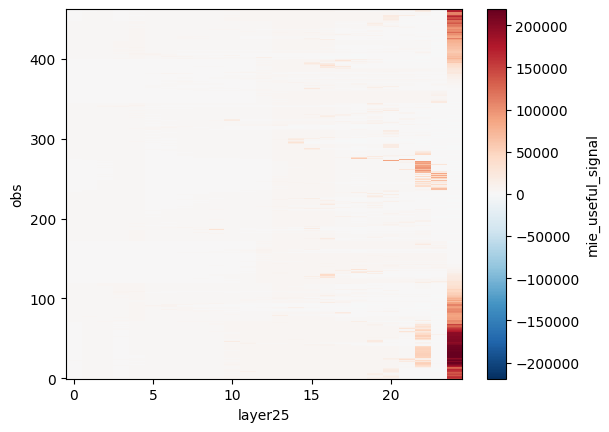

In [14]:
# Do something with the dataset 
ds["mie_useful_signal"].plot()

## Downloading data 
You can also use your token and the url to download data and not just stream it / load it into memory. 

In [15]:
import requests
def download_file_with_bearer_token(url, token, disable_bar=False):
  """
  Downloads a file from a given URL using a Bearer token.
  """

  try:
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes
    file_size = int(response.headers.get('content-length', 0))

    chunk_size = 8 * 1024 * 1024 # Byes - 1MiB
    file_path = url.rsplit('/', 1)[-1] 
    print(file_path)
    with open(file_path, "wb") as f, tqdm(
        desc=file_path,
        total=file_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
        disable=disable_bar,
      ) as bar:
      for chunk in response.iter_content(chunk_size=chunk_size):
        read_size=f.write(chunk)
        bar.update(read_size)

    if (disable_bar): 
      print(f"File downloaded successfully to {file_path}")

  except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")

In [16]:
# Point to any URL of your choice in the STAC assets
download_file_with_bearer_token(l1b_url, token)

AE_OPER_ALD_U_N_1B_20230422T165721033_005543989_027018_0001.DBL


AE_OPER_ALD_U_N_1B_20230422T165721033_005543989_027018_0001.DBL: 100%|██████████| 27.3M/27.3M [00:00<00:00, 39.2MiB/s]
